In [30]:
import numpy as np

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm
from scipy.interpolate import PchipInterpolator
from scipy.signal import savgol_filter

In [2]:
from proteus.config import read_config
from proteus.utils.constants import M_earth, R_earth
import utils.load_grid as lg

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [4]:
pgrid_dir = "data/output/l98d_escape14/"
cases = lg.get_cases(pgrid_dir, only_completed=True)
ncases = len(cases)

In [5]:
cnums = [int(s.split("_")[-1]) for s in cases]
stts = lg.get_statuses(pgrid_dir)
helps, hvars = lg.load_helpfiles(cases)

confs = []
for f in cases:
    confs.append( read_config(f+"/init_coupler.toml") )

transit, eclipse = lg.load_synthobs(cases)

print("Done")

Synthobs: 100%|██████████| 138/138 [00:26<00:00,  5.11it/s]

Done


In [6]:
g24_ts = pd.read_csv("data/reference/l9859/gressier24_transitspectroscopy_d.dat", delimiter=' ')
g24_ts_x = g24_ts["central_wavelength(microns)"]
g24_ts_y = g24_ts["transit_depth"] * 1e6
g24_ts_e = g24_ts["transit_depth_error"] * 1e6

g24_ff = pd.read_csv("data/reference/l9859/gressier24_firefly_d.dat", delimiter=' ')
g24_ff_x = g24_ff["central_wavelength(microns)"]
g24_ff_y = g24_ff["transit_depth"] * 1e6
g24_ff_e = g24_ff["transit_depth_error"] * 1e6

g24_fc = pd.read_csv("data/reference/l9859/gressier24_freechem_d.dat", delimiter=' ')
g24_fc_x = g24_fc["central_wavelength(microns)"]
g24_fc_y = g24_fc["best_fit_transit_depth"] * 1e6
g24_fc_e = g24_fc["1_sigma_uncertainty"] * 1e6

z23 = pd.read_csv("data/reference/l9859/zhou23_hst_d.dat", delimiter=' ')
z23_x = z23["wavelength_um"]
z23_y = z23["obs_transit_depth"] * 1e6
z23_e = z23["obs_transit_depth_error"] * 1e6

In [ ]:
tra_x = np.append(z23_x, g24_ff_x)
tra_y = np.append(z23_y, g24_ff_y)

mask = np.argsort(tra_x)
tra_x = tra_x[mask]
tra_y = tra_y[mask]

def synth_itp(synth_x, synth_y):
    itp = PchipInterpolator(synth_x, synth_y)
    return itp(tra_x)

def chi2_itp(obs, exp):
    chi2 = 0.0
    for i in range(len(obs)):
        chi2 += (obs[i] - exp[i])**2 / exp[i]
    return chi2

Included cases: 53
outgas.fO2_shift_IW


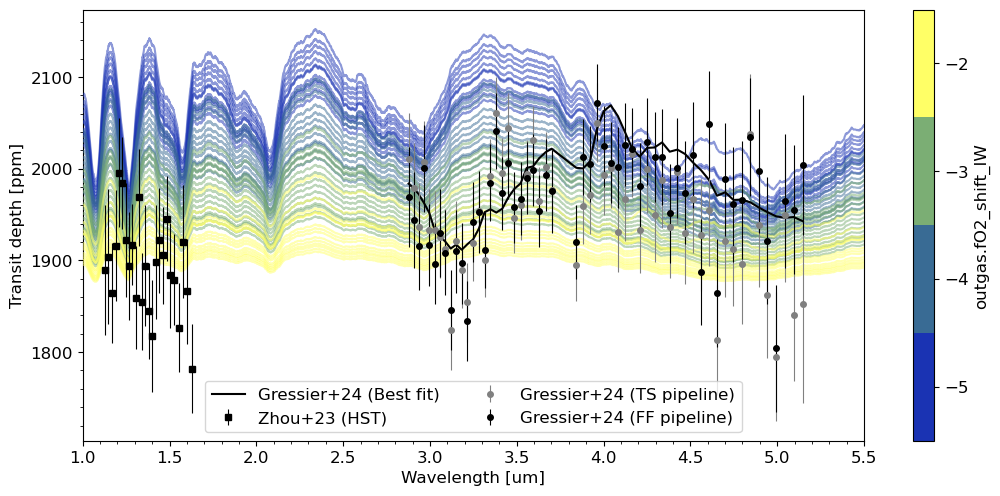

Case	 zval	 Chi2
149	 -2	 199.156
152	 -2	 202.098
170	 -2	 205.699
182	 -2	 207.643
119	 -3	 210.935
140	 -3	 211.348
128	 -3	 211.668
131	 -3	 213.317
116	 -3	 214.267
143	 -3	 216.903
161	 -2	 218.49
146	 -2	 220.237
137	 -3	 220.558
173	 -2	 223.868
125	 -3	 227.492
185	 -2	 229.728
113	 -3	 237.477
164	 -2	 239.622
107	 -3	 245.52
176	 -2	 247.045
188	 -2	 254.424
167	 -2	 259.652
179	 -2	 267.556
134	 -3	 271.803
 95	 -4	 274.495
191	 -2	 275.505
104	 -3	 286.938
122	 -3	 288.416
 83	 -4	 294.868
110	 -3	 309.967
 71	 -4	 319.201
 92	 -4	 326.549
 80	 -4	 354.503
101	 -3	 366.217
 68	 -4	 385.156
 89	 -4	 415.904
 77	 -4	 448.287
 65	 -4	 489.115
 47	 -5	 541.426
 86	 -4	 571.448
 35	 -5	 581.7
 74	 -4	 610.916
 23	 -5	 628.892
 44	 -5	 646.956
 62	 -4	 654.411
 32	 -5	 674.526
 20	 -5	 742.256
 41	 -5	 750.863
 29	 -5	 797.955
 17	 -5	 858.214
 38	 -5	 910.984
 26	 -5	 963.226
 14	 -5	 1061.18


In [58]:
figscale = 1.4
fig,ax = plt.subplots(1,1, figsize=(9*figscale,4*figscale))

zkey = "outgas.fO2_shift_IW"
zscl = "linear"
zfct = 1.0
ctrl = {"struct.mass_tot":2.39}
ykey = "None/ppm"
yvar = transit
ylbl = "Transit depth [ppm]"
dsmp = 2
xlim = (1.0, 5.5)

def get_val(conf, help, key):
    if "." in key:
        z = lg.descend_get(conf, key)
    else:
        z = help[key].iloc[-1]
    return z

# work out which cases match control variables
incl = []
for i in range(ncases):
    is_incl = True
    for k in ctrl.keys():
        if not np.isclose(lg.descend_get(confs[i],k),ctrl[k]):
            is_incl = False
    if is_incl:
        incl.append(i)
print("Included cases: %d"%len(incl))

# get range for zkey
print(zkey)
zvals = []
for i in incl:
    zvals.append(get_val(confs[i], helps[i], zkey)*zfct)
zvals = np.unique(zvals)
if zscl == "log":
    norm = mpl.colors.LogNorm(vmin=zvals[0], vmax=zvals[-1])
else:
    norm = mpl.colors.Normalize(vmin=zvals[0], vmax=zvals[-1])
sm = plt.cm.ScalarMappable(cmap=cm.imola, norm=norm)
sm.set_array([])

# plot sims
chi2_arr = []
z_arr = []
rho_arr = []
for i in incl:
    cfg = confs[i]

    x = np.array(yvar[i]["Wavelength/um"])
    y = np.array(yvar[i][ykey])
    z = get_val(confs[i], helps[i], zkey)

    if len(x) < 2:
        continue

    x_bin = tra_x
    y_bin = synth_itp(x, y)
    # ax.scatter(x_bin, y_bin, color=sm.to_rgba(z), alpha=0.5, zorder=4, marker='s', edgecolor='none', s=10)

    x_smth = np.array(x)
    y_smth = savgol_filter(y, 200, 5)
    ax.plot(x_smth, y_smth, color=sm.to_rgba(z), alpha=0.5, zorder=3)


    rho_arr.append(helps[i]["rho_obs"].iloc[-1])
    z_arr.append(z)
    chi2_arr.append(chi2_itp(y_bin, tra_y))

# plot literature
ax.errorbar(z23_x, z23_y, yerr=z23_e, label="Zhou+23 (HST)", color="black",
                zorder=4, fmt='s', markersize=4, elinewidth=0.8)
ax.plot(g24_fc_x, g24_fc_y, label="Gressier+24 (Best fit)", color="black", zorder=4,)
ax.errorbar(g24_ts_x, g24_ts_y, yerr=g24_ts_e, label="Gressier+24 (TS pipeline)", color="grey",
                zorder=4, fmt='o',  markersize=4, elinewidth=0.8)
ax.errorbar(g24_ff_x, g24_ff_y, yerr=g24_ff_e, label="Gressier+24 (FF pipeline)", color="black",
                zorder=4, fmt='o',  markersize=4, elinewidth=0.8)


ax.set(xlabel="Wavelength [um]", xlim=xlim)
ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_minor_locator(MultipleLocator(0.1))

ax.set(ylabel=ylbl)
ax.yaxis.set_major_locator(MultipleLocator(100))
ax.yaxis.set_minor_locator(MultipleLocator(20))

if len(zvals) > 5:
    fig.colorbar(sm, ax=ax, label=zkey)
else:
    fig.colorbar(sm, ax=ax, label=zkey, values=zvals, ticks=zvals)
ax.legend(loc='lower center', ncols=2)
plt.show()
fig.savefig("output/transit.pdf", bbox_inches='tight')


print("Case\t zval\t Chi2")
for j in np.argsort(chi2_arr):
    print("%3d\t %g\t %g"%(cnums[incl[j]], z_arr[j], chi2_arr[j]))